# Predicting The Outcome of Kickstarter Projects


## Abstract

(Insert abstract here)

## What is Kickstarter

To put it in their own words “Kickstarter helps artists, musicians, filmmakers, designers, and other creators find the resources and support they need to make their ideas a reality. To date, tens of thousands of creative projects — big and small — have come to life with the support of the Kickstarter community.”

It is a platform that allows creators to transform ideas through the use of crowdfunding from backers in order to create tangible products. Creators are the people that set deadlines with funding goals that need to be met in order for them to create their projects, as well as stretch goals that may be created if that goal is surpassed. Projects can also have their deadlines extended and funding goals adjusted after the fact

## About the Data

In this dataset lies a collection of 378,661 projects from April 2009 to January 2018 that contain a wide variety of project types and goals. The columns provided in the dataset are the
1. Project ID
2. Project name
3. Category
4. Main category
5. Currency type (USD,  EUR, GBP, etc.)
6. Deadline
7. Goal
8. Launch date
9. Pledged amount
10. State of the project (Successful, failed, cancelled, live, suspended)
11. Number of backers
12. Country of origin
13. USD pledged
14. USD pledged real
15. USD goal real

## Research Question

Now, the goal of this project is to determine what factors ultimately determine the success (or failure) of a kickstarter project, given the tools at our disposal.

## Packages

In [1]:
# Import basic statements
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import HTML

# Import visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Plotly packages
import plotly as py
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

## Data Preview

In [2]:
# Import data and sort by deadline date
kickstart_data = pd.read_csv("ks-projects-201801.csv")

# Drop all empty rows
kickstart_data.dropna()

# Preview the data, ordered by deadline
kickstart_data.sort_values('deadline').head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
138572,1703704063,drawing for dollars,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,35.0,successful,3,US,35.0,35.0,20.0
213711,2089078683,New York Makes a Book!!,Journalism,Journalism,USD,2009-05-16,3000.0,2009-04-28 13:55:41,3329.0,successful,110,US,3329.0,3329.0,3000.0
342226,813230527,Sponsor Dereck Blackburn (Lostwars) Artist in ...,Rock,Music,USD,2009-05-16,300.0,2009-04-29 05:26:32,15.0,failed,2,US,15.0,15.0,300.0
28960,1147015301,"""All We Had"" Gets Into Cannes -- $10 or More G...",Documentary,Film & Video,USD,2009-05-20,300.0,2009-04-30 22:10:30,40.0,failed,4,US,40.0,40.0,300.0
196244,199916122,Mr. Squiggles,Illustration,Art,USD,2009-05-22,30.0,2009-05-12 23:39:58,0.0,failed,0,US,0.0,0.0,30.0


In [3]:
# Check the size of our dataset
kickstart_data.shape

(378661, 15)

In [4]:
# Print out column names and # of unique values in each categorical variable
kickstart_data.select_dtypes(include=['object']).nunique()

name             375764
category            159
main_category        15
currency             14
deadline           3164
launched         378089
state                 6
country              23
dtype: int64

## Data Cleaning

In [5]:
# Convert 'launched' and 'deadline' columns into dates
kickstart_data['launched'] = kickstart_data['launched'].astype('datetime64[ns]')
kickstart_data['deadline'] = pd.to_datetime(kickstart_data['deadline'])
kickstart_data['launched'] = pd.DatetimeIndex(kickstart_data.launched).normalize()

# Project duration is more useful and less data
# than the launch date and deadline
kickstart_data['duration'] = kickstart_data['deadline'] - kickstart_data['launched']
kickstart_data['duration'] = (kickstart_data['duration'] / np.timedelta64(1, 'D')).astype(int)
kickstart_data.drop(['launched', 'deadline'], 1, inplace=True)

# Drop variables that have no impact on the outcome, and
# variables that have over 15 unique values
kickstart_data.drop(['ID', 'name', 'category', 'currency', 'goal', 'pledged', 'usd pledged'], 1, inplace=True)

# Rename usd_pledged_real and usd_goal_real to 
# pledged and goal
kickstart_data = kickstart_data.rename(index=str, columns = {'usd_pledged_real': 'pledged', 
                                                             'usd_goal_real': 'goal', 
                                                             'main_category': 'category'})

## Exploratory Data Analysis

In [6]:
# Summary of the dataset
kickstart_data.describe()

,backers,pledged,goal,duration
count,378661.000000,3.786610e+05,3.786610e+05,378661.000000
mean,105.617476,9.058924e+03,4.545440e+04,34.481095
std,907.185035,9.097334e+04,1.152950e+06,65.909173
min,0.000000,0.000000e+00,1.000000e-02,1.000000
25%,2.000000,3.100000e+01,2.000000e+03,30.000000
50%,12.000000,6.243300e+02,5.500000e+03,30.000000
75%,56.000000,4.050000e+03,1.550000e+04,37.000000
max,219382.000000,2.033899e+07,1.663614e+08,16739.000000


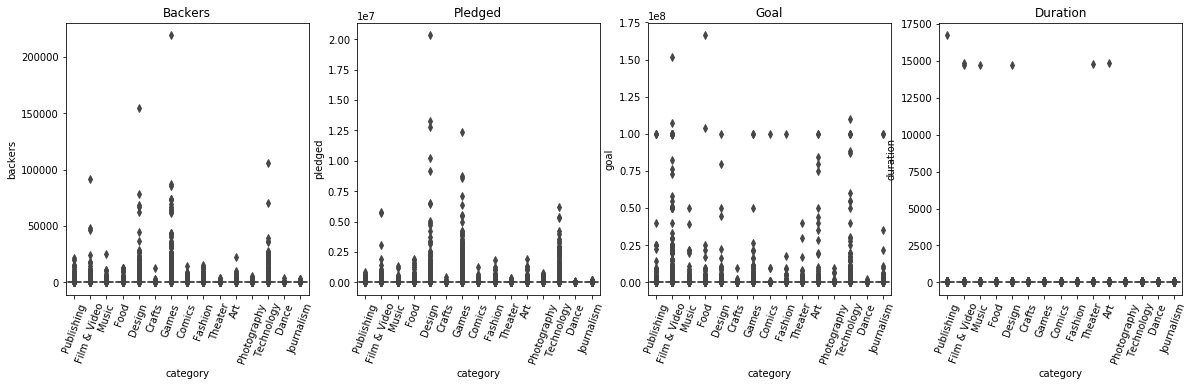

In [7]:
# Plot all of variables, and try to identify outliers
plt.rcParams['figure.figsize'] = [20,5]

plt.subplot(1,4,1)
plt.title('Backers')
plt.xticks(rotation=70)
ax = sns.boxplot(x="category", y="backers", data=kickstart_data)

plt.subplot(1,4,2)
plt.title('Pledged')
plt.xticks(rotation=70)
ax = sns.boxplot(x="category", y="pledged", data=kickstart_data)

plt.subplot(1,4,3)
plt.title('Goal')
plt.xticks(rotation=70)
ax = sns.boxplot(x="category", y="goal", data=kickstart_data)

plt.subplot(1,4,4)
plt.title('Duration')
plt.xticks(rotation=70)
ax = sns.boxplot(x="category", y="duration", data=kickstart_data)

Well, one of the great things about Kickstarter is that there are technically no limits to the scale of the projects that can emerge from the platform. Feel free to look at Star Citizen if you were wondering what project generated over 2 million dollars in pledges.

<a href="https://www.kickstarter.com/projects/cig/star-citizen">Star Citizen</a>



So, the problem is that there are quite a lot of ambitious projects that drew in a substantial amount of backers with goals far above 75% of other projects, resulting in the messy distribution above. The duration variable looks like there are few enough genuine outliers for us to examine. As for the rest, it seems like we'll need to transform them before proceeding because there are simply too many outliers for us to ignore.

In [8]:
# Order by duration
kickstart_data.sort_values('duration', ascending = False).head(10)

,category,state,backers,country,pledged,goal,duration
319002,Publishing,suspended,0,CH,0.0,1905.97,16739
2842,Film & Video,canceled,0,US,0.0,5000.00,14867
48147,Art,canceled,0,US,0.0,15000.00,14835
94579,Theater,canceled,0,US,0.0,4000.00,14761
75397,Film & Video,canceled,0,US,0.0,700.00,14750
247913,Music,canceled,0,US,0.0,10000.00,14733
273779,Design,canceled,0,US,0.0,500.00,14709
200310,Film & Video,failed,0,US,0.0,250000.00,92
38476,Technology,failed,1,US,100.0,65000.00,92
305126,Film & Video,failed,4,US,1530.0,20000.00,92


As we had expected earlier, it seems as though out of 370,000+ projects, only 7 of them seem to have a suspiciously long duration at well over 10,000 days. The rest of the projects in this dataset last no more than 92 days. Since this is an extremely small subset of rows from our dataframe, we can safely remove them from the dataset before proceeding.

In [9]:
# Drop our 7 outliers from the dataset based on duration
kickstart_data.drop(kickstart_data.sort_values('duration', ascending = False).head(7).index, axis=0, inplace = True)

## Feature Engineering

In [10]:
# Applying log transformations to 'backers', 'pledged', and 'goal' columns
kickstart_data['backers'] = np.log(kickstart_data['backers'] + 1)
kickstart_data['pledged'] = np.log(kickstart_data['pledged'] + 1)
kickstart_data['goal'] = np.log(kickstart_data['goal'] + 1)

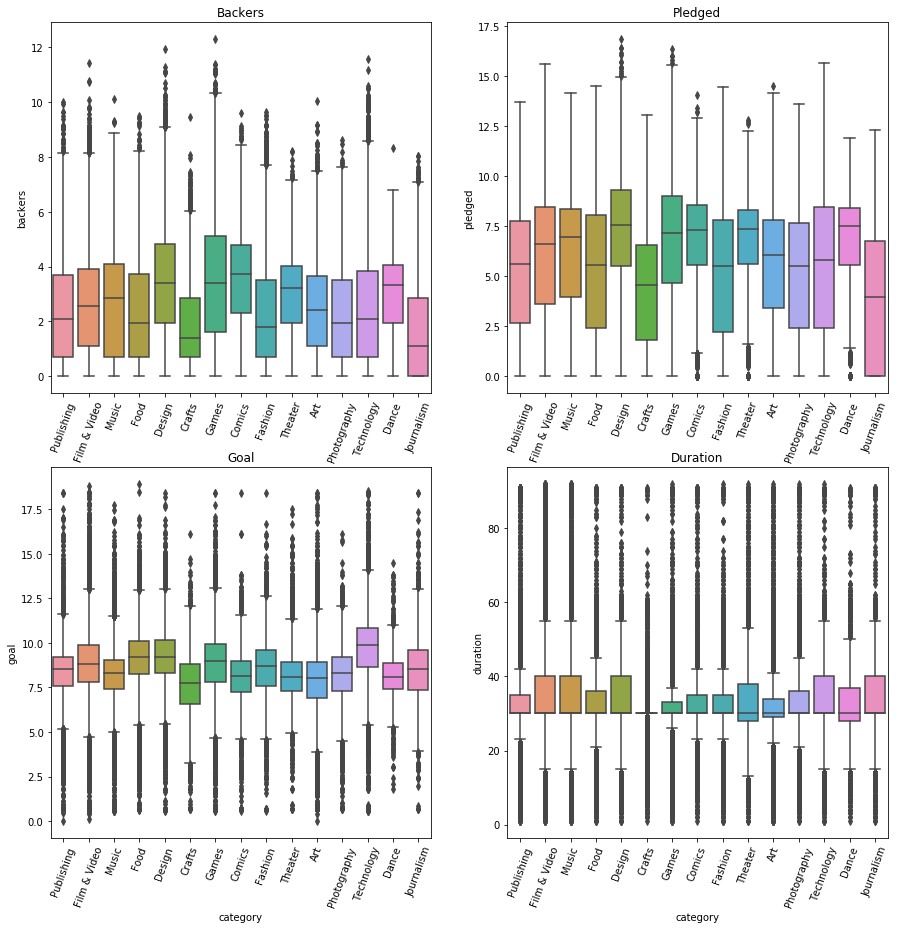

In [11]:
# Plot all of variables, and try to identify outliers
plt.rcParams['figure.figsize'] = [15,15]

plt.subplot(2,2,1)
plt.title('Backers')
plt.xticks(rotation=70)
ax = sns.boxplot(x="category", y="backers", data=kickstart_data)

plt.subplot(2,2,2)
plt.title('Pledged')
plt.xticks(rotation=70)
ax = sns.boxplot(x="category", y="pledged", data=kickstart_data)

plt.subplot(2,2,3)
plt.title('Goal')
plt.xticks(rotation=70)
ax = sns.boxplot(x="category", y="goal", data=kickstart_data)

plt.subplot(2,2,4)
plt.title('Duration')
plt.xticks(rotation=70)
ax = sns.boxplot(x="category", y="duration", data=kickstart_data)

So after removing our outliers from the 'duration' column, and applying a log transformation to the 'backers', 'pledged', and 'goal' columns, we can see a somewhat normal distribution.

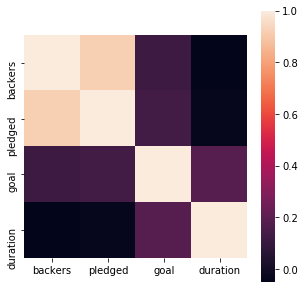

In [12]:
# Creates a correlation matrix among the predictor variables
plt.rcParams['figure.figsize'] = [5,5]

correlation_martix = kickstart_data.corr()
sns.heatmap(correlation_martix, vmax = 1, square = True)
plt.show()

There appears to be a very high degree of similarity between the number of backers, and total monetary amount contributed. This makes sense if we assume that each backer donates roughly the same amount, leading to two columns that have quite a lot in common. We can try removing one or the other later if we need to determine which of these factors is more important than the other. For now, we'll use both predictors in our model.

In [13]:
# Drop backers and pledged from the dataset since they are dependent variables
kickstart_data.drop(['backers', 'pledged'], 1, inplace=True)

(-1.2248786255360546,
 1.2131965717027007,
 -1.212274366954329,
 1.2109555139336867)

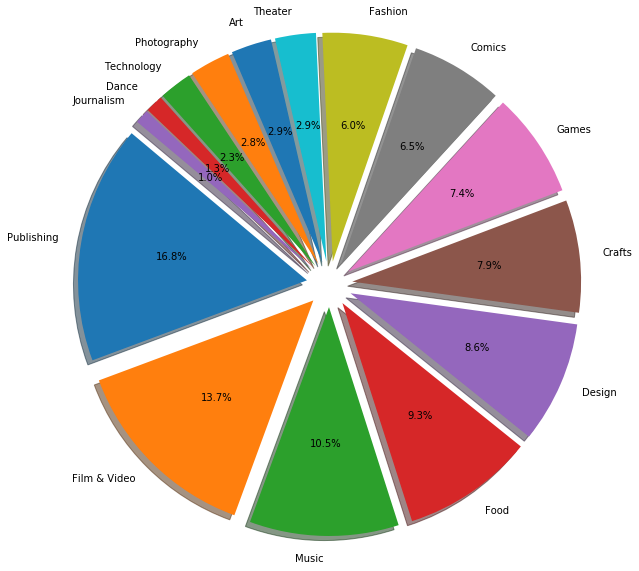

In [14]:
plt.rcParams['figure.figsize'] = [10,10]

# Creates a pie chart that represents the different categories in our dataset
plt.pie(kickstart_data['category'].value_counts(), explode = np.ones(15)*0.1, labels=kickstart_data['category'].unique(),
        labeldistance = 1.1, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

Kickstarter divides their main categories into 14 distinct groups of unequal size. Publishing, at 16.8% (63,000 projects), is the largest category in the dataset, while journalism is a little under 1% (3768 projects). While the distribution is unfortunately unbalanced, that is the data that we have, and we still have plenty of observations for each category to work with.

In [15]:
# This pie chart looks a lot better, but it does not play well with github due to its interactivity
# To view plotly images, please copy/paste this url to https://nbviewer.jupyter.org/

# Pass in values for our pie chart
trace = go.Pie(labels=kickstart_data['category'].unique(), values = kickstart_data['category'].value_counts())

# Create the layout
layout = go.Layout(
    title = 'Kickstarter Projects by Category',
    height = 600,
    width = 800,
    autosize = False
)

# Construct the chart
fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig, filename ='cufflinks/simple')

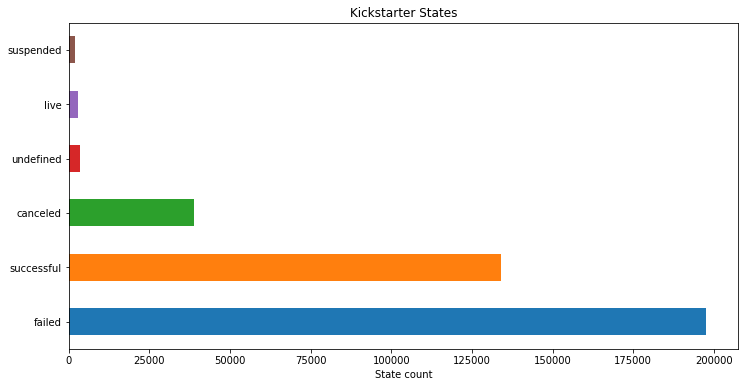

In [16]:
# Plot kickstarter states
plt.rcParams['figure.figsize'] = [12,6]
plt.title('Kickstarter States')
plt.xlabel('State count')
kickstart_data['state'].value_counts().plot(kind='barh')

So in this dataset, the six possible states for a project are suspended, live, undefined, canceled, successful, and failed. The first three states have very few values, relative to what we really want to know - if a project succeeds or fails. In addition, if we do want to utilize these three columns, we would need to look at the following factors.
1. A follow up to investigate the reason for a project to be suspended
2. Live projects can fall into either category - success or failure
3. Undefined is a result that we can't interpret or use.

Success and failure are easy to define, and can be recoded as 1 and 0 so that we can predict the outcome as an easily modelable binary variable. Cancellation is generally caused by the inability to meet a project's demands for a multitude of reasons leading to lack of funding or interest, or inability to finish the project. It would simplify the following models to treat cancellation the same as failure.

In [17]:
# Remove 'suspended', 'live', and 'undefined' states from the dataset
kickstart_data = kickstart_data[kickstart_data.state != ('suspended', 'live', 'undefined')]

# Consolidate 'canceled' and 'failed' into one category
kickstart_data['state'] = np.where(kickstart_data.state == 'successful', 1, 0)
success_rate = kickstart_data['state']

(-1.1154681955525665,
 1.1143348565040996,
 -1.1132377615610414,
 1.117099503783597)

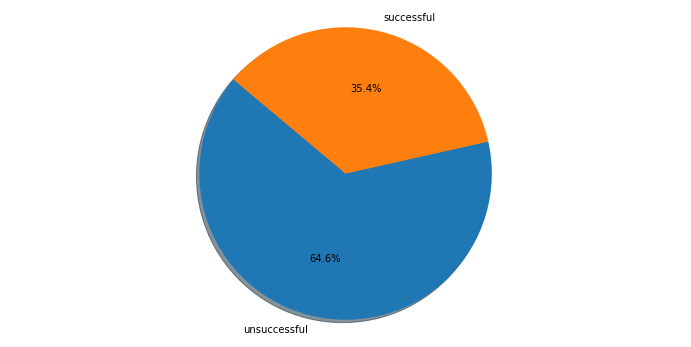

In [18]:
# Constructs a pie chart displaying our final successful and unsuccessful values
plt.pie(np.bincount(success_rate), labels=['unsuccessful', 'successful'],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

After removing 3 of the project states, and combining cancelled and failed into 1 state, we end up with 35.4% projects succeeding, and 67.6% failing. The outcome is a bit unbalanced, so it will be necessary to keep in mind that there will most likely be some bias in the predictive variables towards unsuccessful projects.

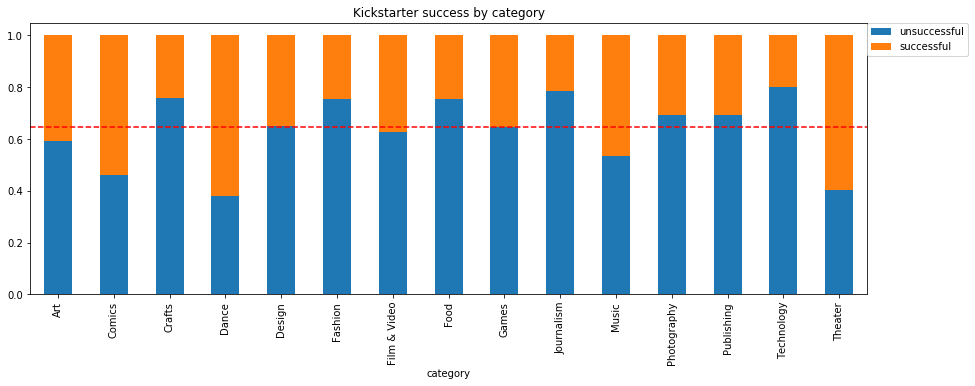

In [19]:
plt.rcParams['figure.figsize'] = [15,5]

# Finds percentages of all categories
container = kickstart_data.groupby(['category', 'state'])['category'].count().unstack('state')
totals = kickstart_data.groupby(['category'])['state'].count()
container = container.div(totals, axis = 0)

# Plots the bar chart
container.columns = ['unsuccessful', 'successful']
container.plot(kind='bar', stacked=True)
plt.title('Kickstarter success by category')
plt.axhline(y=0.646, color='r', ls='--')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.show()

<div class="alert alert-block alert-warning">
The dotted red line above represents the line between success/ failure in the entire dataset.
</div>

Earlier in the page, we investigated the size of each category in the dataset, and noticed that the groups are not equal, meaning some groups have a higher impact on the average outcome than others. Above, we see that the categories do not mirror the average results with some categories being much more successful than not, such as dance and theater, while certain others don't fare quite as well such as journalism and technology.

In [20]:
kickstart_data.groupby(['country']).size()

country
AT         597
AU        7839
BE         617
CA       14756
CH         760
DE        4171
DK        1113
ES        2276
FR        2939
GB       33672
HK         618
IE         811
IT        2878
JP          40
LU          62
MX        1752
N,0"      3797
NL        2868
NO         708
NZ        1447
SE        1757
SG         555
US      292621
dtype: int64

As an American company and one of the largest countries in the list, it's not too surprising to see that the vast majority of projects were created in the United States. Given the vast difference in population size of the projects, this may not be the most useful category for prediction. 

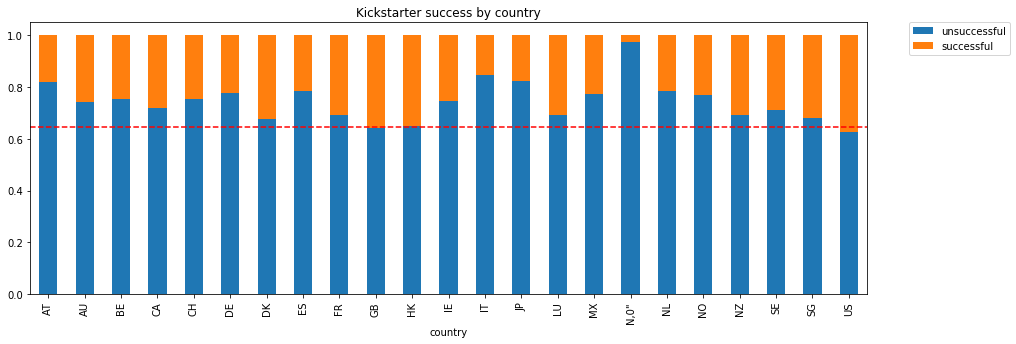

In [21]:
# Finds percentages of all countries
container = kickstart_data.groupby(['country', 'state'])['country'].count().unstack('state')
totals = kickstart_data.groupby(['country'])['state'].count()
container = container.div(totals, axis = 0)

# Plots the bar chart
container.columns = ['unsuccessful', 'successful']
container.plot(kind='bar', stacked=True)
plt.title('Kickstarter success by country')
plt.axhline(y=0.646, color='r', ls='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Well isn't that ... not all that interesting? It seems like only 3 of the countries have a success rate greater than average, one of which is the US, which heavily skews the result. The success rate is quite a bit lower in the majority of other available countries, but it hardly has an impact on the average.

In [22]:
# Create separate dataframe for numerical values
numerical = kickstart_data.select_dtypes(exclude=['object'])

# Create separate dataframe for categorical values
categorical = pd.get_dummies(kickstart_data.select_dtypes(include='object'))

# Create the combined dataframe
kickstart_data = pd.concat([numerical, categorical], axis=1, sort = False)

# Remove the 'state' column from our dataset
# since it's not a predictor, it's the outcome
kickstart_data.drop(['state'], axis = 1, inplace = True)

In order to make use of the categorical variables in the dataset, category and country, they'll first need to be recoded to 1s and 0s so that they can be interpretted.

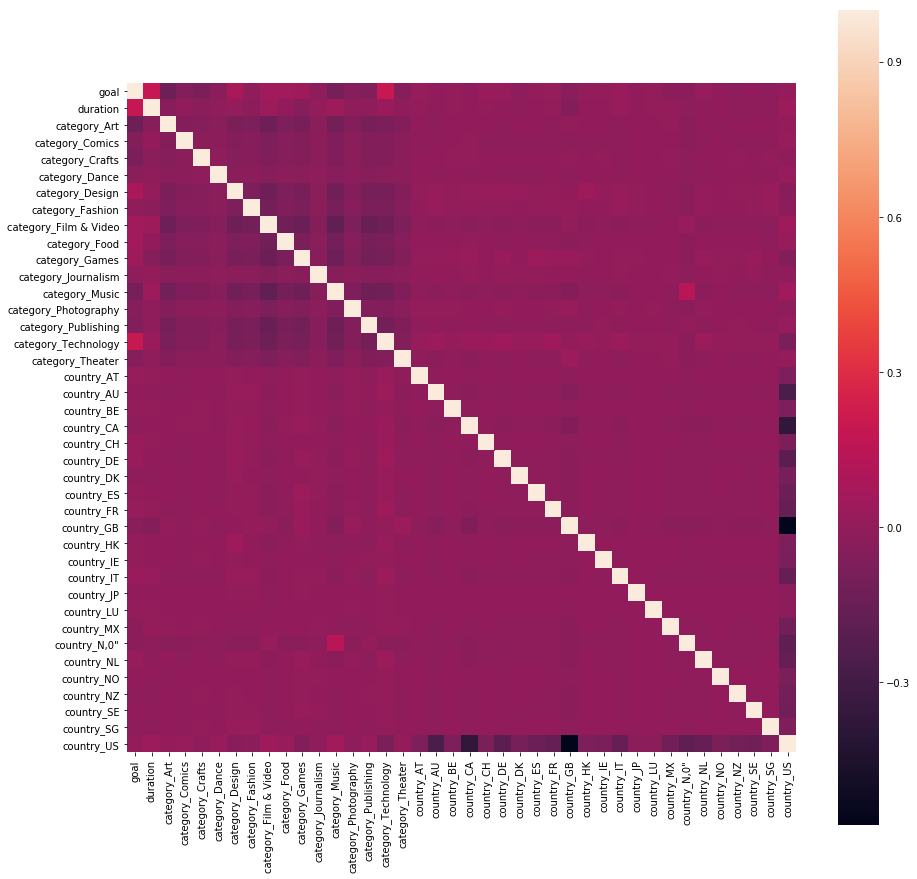

In [23]:
plt.rcParams['figure.figsize'] = [15,15]

# Creates a correlation matrix among the predictor variables
correlation_martix = kickstart_data.corr()
sns.heatmap(correlation_martix, vmax = 1, square = True)
plt.show()

By re-examining our correlation matrix after recoding the categorical variables, the results are the same as before, except we can also confirm that the different values in category and country have no correlation to each other, or any other variable.

Now that we've examined and prepared our dataset, it's time to get to the fun part, modeling.

# Modelling

In [49]:
# Machine learning packages
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [25]:
# Divide the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(kickstart_data, success_rate, test_size=0.3)

## Logistic Regression Model

Let's start out with one of the simplest and quickest models for predicting outcomes, logistic regression. This model will determine the correlation between each of our 5 predictor variables and outcome, then weigh the correlations depending on the strength of the relationships. 

In [26]:
# Packages for linear regression modelling
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

In [55]:
# Constructs a logistic regression model
lr = LogisticRegression(C = 1, random_state=0)

# Fit the logistic regression to the training data
lr.fit(X_train, y_train)

# Store the predicted values in a dataframe
y_pred = lr.predict(X_test)

# Print accuracy of test set
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.68


In [56]:
# Checks the accuracy of the model using cross validation
cv1 = cross_val_score(lr, X_train, y_train, cv=10)  
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(cv1.mean(), cv1.std()*2))

cv2 = cross_val_score(lr, X_test, y_test, cv=10)  
print('Cross Validation Accuracy Scores - Testing Set: {:.5f}(+/- {:.2f})'.format(cv2.mean(), cv2.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.67465(+/- 0.00)
Cross Validation Accuracy Scores - Testing Set: 0.67490(+/- 0.00)


In [29]:
# Create a confusion matrix
confusion_matrix(y_test, y_pred)

array([[64677,  8918],
       [27958, 12044]], dtype=int64)

In [30]:
# Print model statisitcs
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.70      0.88      0.78     73595
          1       0.57      0.30      0.40     40002

avg / total       0.65      0.68      0.64    113597



So, our initial model has a predictive accuracy of 67.49 (+/- 0) %. It's not great, so let's see if we can improve it by tuning the parameters. 

In [54]:
tuned_parameters = [{'penalty': ['l1', 'l2'],
                     'C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']
for score in scores:
    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Best parameters set found on development set:

{'C': 1, 'penalty': 'l2'}

Grid scores on development set:

0.638 (+/-0.005) for {'C': 1, 'penalty': 'l1'}
0.638 (+/-0.005) for {'C': 1, 'penalty': 'l2'}
0.638 (+/-0.005) for {'C': 10, 'penalty': 'l1'}
0.638 (+/-0.005) for {'C': 10, 'penalty': 'l2'}
0.638 (+/-0.005) for {'C': 100, 'penalty': 'l1'}
0.638 (+/-0.005) for {'C': 100, 'penalty': 'l2'}
0.638 (+/-0.005) for {'C': 1000, 'penalty': 'l1'}
0.638 (+/-0.005) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.70      0.88      0.78     73595
          1       0.57      0.30      0.40     40002

avg / total       0.65      0.68      0.64    113597


Best parameters set found on development set:

{'C': 100, 'penalty': 'l2'}

Grid scores on development set:

0.591 (+/-0.003) for {'C': 1, 'penalty': 'l

Well, this is unfortunate. It appears as though tuning the model to improve precision and recall result in the same accuracy and matches our previous result. Let's see if our more complex models can fare any better.

## Decision Trees

In [65]:
# Packages for modelling decision trees
from sklearn import ensemble
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
from sklearn.ensemble import RandomForestClassifier

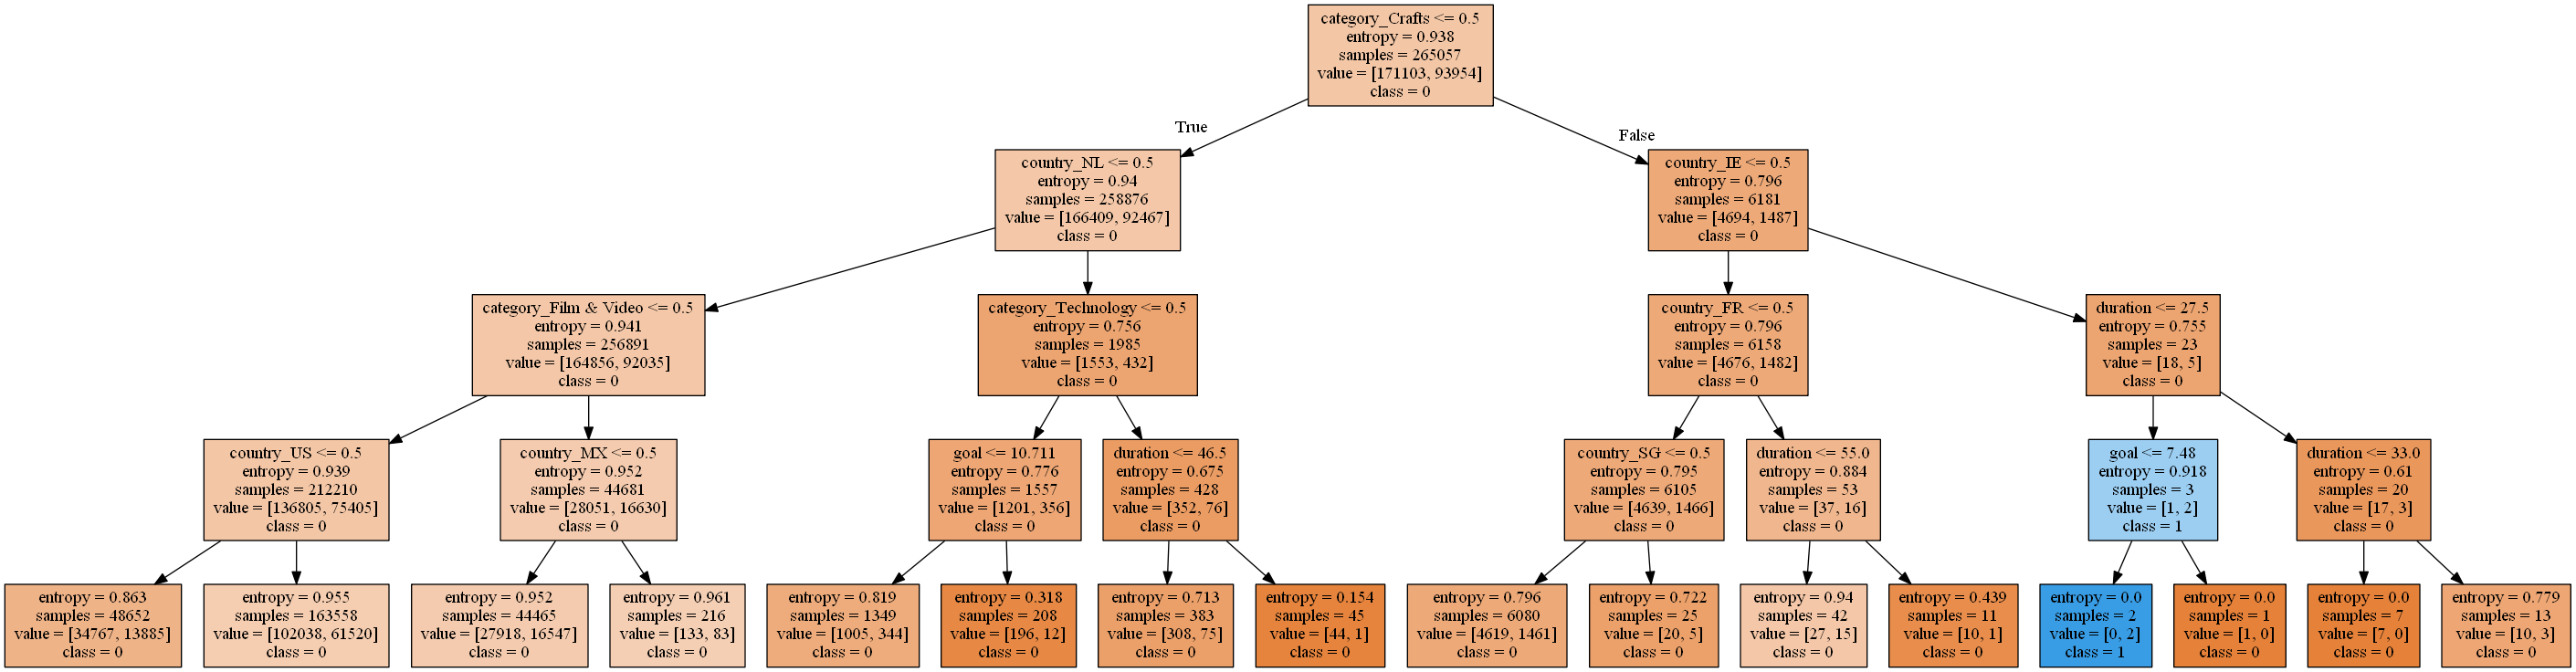

In [32]:
# Constructing the shape of our decision tree
decision_tree = tree.DecisionTreeClassifier(
    criterion = 'entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)
decision_tree.fit(X_train, y_train)
    
# visualizing our decision tree
dot_data = tree.export_graphviz(
    decision_tree, out_file = None,
    feature_names=kickstart_data.columns,
    class_names = ['0', '1'],
    filled = True
 )

# Constructing our random forest
rfc = ensemble.RandomForestClassifier()

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [73]:
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

# Constructing the shape of our decision tree

clf = RandomForestClassifier(n_estimators=20)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV took 151.72 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.684 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 8, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.682 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 9, 'min_samples_split': 9}

Model with rank: 3
Mean validation score: 0.682 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 8}

GridSearchCV took 1639.07 seconds for 216 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.685 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 2
Mean validation score

In [74]:
# Cross validation test with 10 samples
cv3 = cross_val_score(rfc, X_train, y_train, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(cv3.mean(), cv3.std()*2))

cv4 = cross_val_score(rfc, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(cv4.mean(), cv4.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.65584(+/- 0.00)
Cross Validation Accuracy Scores - Training Set: 0.65091(+/- 0.01)


## Support Vector Machines

In [34]:
from sklearn.svm import SVR

In [35]:
from sklearn.feature_selection import SelectPercentile, f_classif

In [36]:
from sklearn.feature_selection import SelectKBest, f_classif

In [37]:
# # seems like the dataset is a little too accurate, 99th percentile = 34/43 variables
# reduction = SelectPercentile(f_classif, percentile=99)
# X_train = reduction.fit_transform(X_train, y_train)

In [38]:
#reduction = SelectKBest(f_classif, k=3)
#X_train = reduction.fit_transform(X_train, y_train)

In [39]:
#kickstart_data.shape

In [40]:
#X_train.shape

In [41]:
# Reduce the featureset before running the following 3 lines

In [42]:
svr = SVR()
# svr.fit(X_train, y_train)
# svr.score(X_train, y_train)

In [43]:
# # Cross validation test with 10 samples
# cv5 = cross_val_score(rfc, X_train, y_train, cv=10)
# print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(cv5.mean(), cv5.std()*2))

# cv6 = cross_val_score(rfc, X_test, y_test, cv=10)
# print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(cv6.mean(), cv6.std()*2))

# Source:
Kickstarter Data Page - 
https://www.kaggle.com/kemical/kickstarter-projects/data